# PRiAD 4 - test zaliczający

Test obejmuje materiał z ćwiczenia PRiAD4, wymaga także znajmości zagadnień z wcześniejszych ćwiczeń.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# import niezbędnych procedur pakietu scipy i scikit.learn
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# pakiet mlxtend wymaga wcześniejszej instalacji
# w razie problemów z instalacją przez anaconda navigator-a
# należy w Anaconda prompt wpisać:
# pip install mlxtend   
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format

> **Zadanie 1** Wykonaj grupowanie danych zbioru `iris` metodą aglomeracyjną. Oszacuj na podstawie analizy otrzymanych danych (m.in. dendrogramu) jakia jest optymalna liczba grup i najlepszy typ odległości.

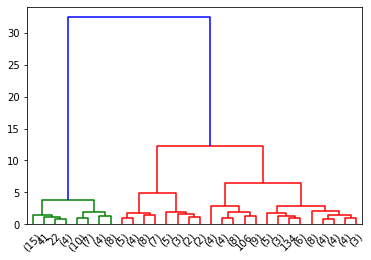

In [14]:
iris = pd.read_csv('iris.csv', index_col = 0)
df = iris.drop(columns = ['species'])
grupy = linkage(df, method = 'ward', metric = 'euclidean')
prog_proc = 70
prog = prog_proc*max(grupy[:,2])/100
cl = dendrogram(grupy, truncate_mode = 'lastp', color_threshold = prog )

Wnioski z analizy wyników zad. 1:
* widać, że 2 grupy charakteryzują się dużym podobieństwem
* grupa w kolorze zielonym znacząco odbiega reprezentowanymi danymi od reszty
* najlepszym typem odległości w tym przypadku jest odległość Warda, ponieważ w największym stopniu różnicuje ona grupy
* optymalna liczba grup w tym przypadku to 2, na co wskazuje dendrogram


> **Zadanie 2** Napisz funkcję, która będzie wizualizować metodę sylwetki i łokciową dla dowolnego zbioru danych (z dowolną liczba atrybutów opisujących). Pierwszym argumentem tej funkcji powinien być zbiór (ramka) danych, drugim - zakres zmian k, trzecim - nazwy dwóch atrybutów wyświetlanych na wykresie punktowym obok wykresu sylwetki. 

In [15]:
#jest to funkcja pomocnicza, główna funkcja to big_function(niżej)
def lokiec(df, k_range, attributes):
    miara_jakosci = pd.Series
    zakres_k = k_range
    ile_w_pionie = int(max(k_range)) + 1
    plt.figure(figsize=(15,45))
    plt.subplot(ile_w_pionie,2,1)
    plt.scatter(df[attributes[0]], df[attributes[1]])
    plt.title('Zbiór danych')
    srednia_odl = []
    pozycja = 2
    for k in k_range:
        plt.subplot(ile_w_pionie,2,pozycja)
        pozycja = pozycja + 1
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(df)
        etykiety_klastrow = kmeans.fit_predict(df)
        plt.scatter(df[attributes[0]], df[attributes[1]], marker='.', c=etykiety_klastrow)
        centroidy = kmeans.cluster_centers_
        plt.scatter(centroidy[:,0], centroidy[:,1], marker='x', c=np.array(range(k)))
        plt.title('k=%s ' % k)
        srednia_odl.append(sum(np.min(cdist(df, centroidy, 'euclidean'), axis=1)) / df.shape[0])
    plt.figure(figsize=(7,5))
    plt.plot(range(2,max(k_range)+1), srednia_odl, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Odległość')
    plt.title('Średnia odległość od centroidu -- wykres łokciowy')
    plt.show()

In [16]:
#jest to funkcja pomocnicza, główna funkcja to big_function(niżej)
def lokiec_sylwetka(df, k_range, attributes):
    miara_jakosci = pd.Series()

    for k in k_range :
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)

        ax1.set_xlim([-0.2, 1])
        ax1.set_ylim([0, len(df) + (k + 1) * 10])
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(df[attributes])
        miara_jakosci = miara_jakosci.append(pd.Series(kmeans.inertia_))
        etykiety_grup = kmeans.fit_predict(df[attributes])
        sylwetka = silhouette_samples(df[attributes], etykiety_grup)
        srednia_sylwetka = silhouette_score(df[attributes], etykiety_grup)

        pozycja_kreski = 10
        for i in range(k):
            sylwetka_w_grupie = sylwetka[etykiety_grup == i]
            sylwetka_w_grupie.sort()
            liczebnosc_grupy = sylwetka_w_grupie.shape[0]
            kolor = cm.tab10(float(i) / k)
            ax1.fill_betweenx(np.arange(pozycja_kreski, pozycja_kreski + liczebnosc_grupy), 0, sylwetka_w_grupie ,color = kolor)
            pozycja_kreski += liczebnosc_grupy + 10
        ax1.set_title("Wykres sylwetek dla poszczegolnych liczb grup")
        ax1.set_xlabel("Wartosc sylwetek")
        ax1.set_ylabel("Etykiety grup")
        ax1.axvline(x = srednia_sylwetka, color = "black", linestyle = "--")
        ax1.set_yticks([])  # Wyczyszczenie etykiety osi Y
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        kolory = cm.tab10(etykiety_grup.astype(float) / k)
        ax2.scatter(df[attributes[0]], df[attributes[1]], marker = '.', s = 30, lw = 0, alpha = 0.7,c = kolory)
        ax2.set_title("Wizualizacja grupowania danych")
        ax2.set_xlabel(attributes[0])
        ax2.set_ylabel(attributes[1])
        plt.suptitle(("Analiza sylwetki k = %d" % k),  fontweight = 'bold')
        plt.figtext(0.14, 0, ("Dla n = %d, średnia wartosc sylwetki wynosi: %.3f, Suma odleglosci od centroidow: %.2f"
                     % (k, srednia_sylwetka, kmeans.inertia_ ) ))
        plt.show()
    plt.plot(k_range, miara_jakosci,'bo-')
    plt.title("Wykres lokciowy", fontsize = 14, fontweight = 'bold')
    plt.xlabel("Liczba grup")
    plt.ylabel("Suma odleglosci od centroidow")

In [17]:
def big_function(df, k_range, attributes):
    lokiec(df, k_range, attributes)
    lokiec_sylwetka(df, k_range, attributes)

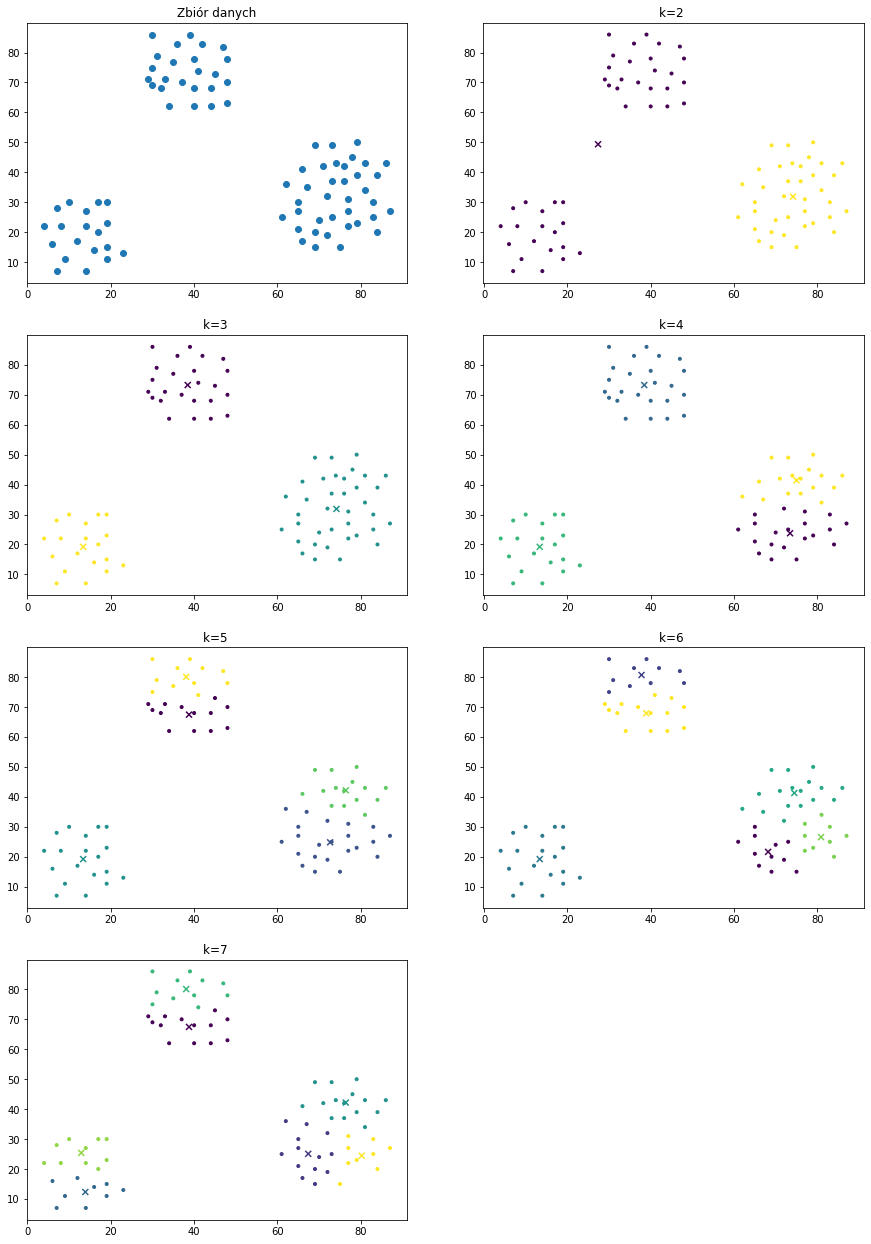

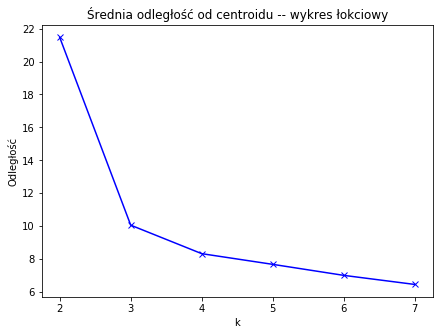

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


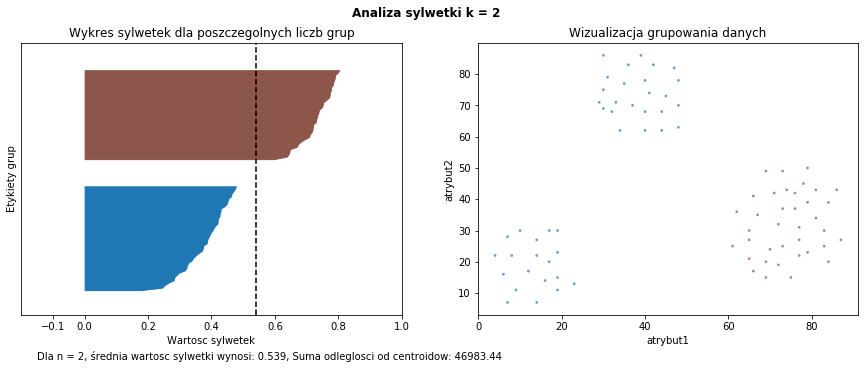

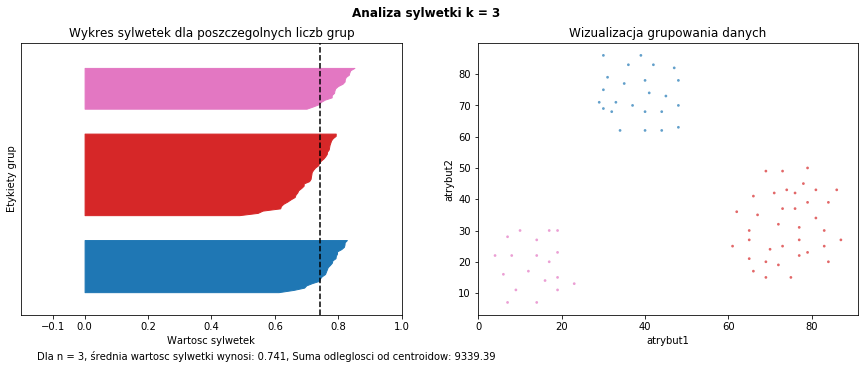

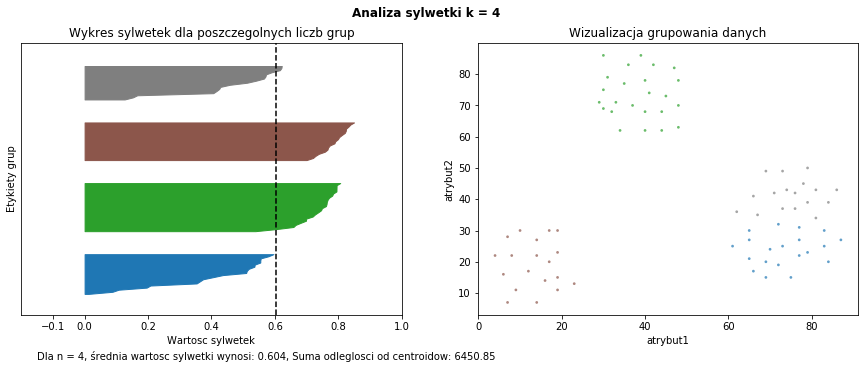

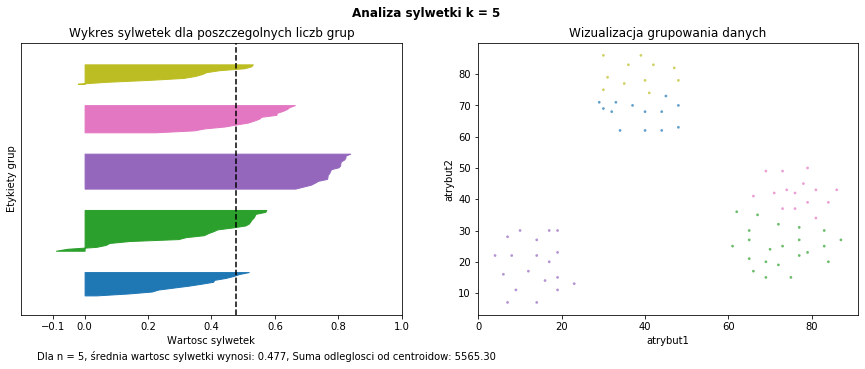

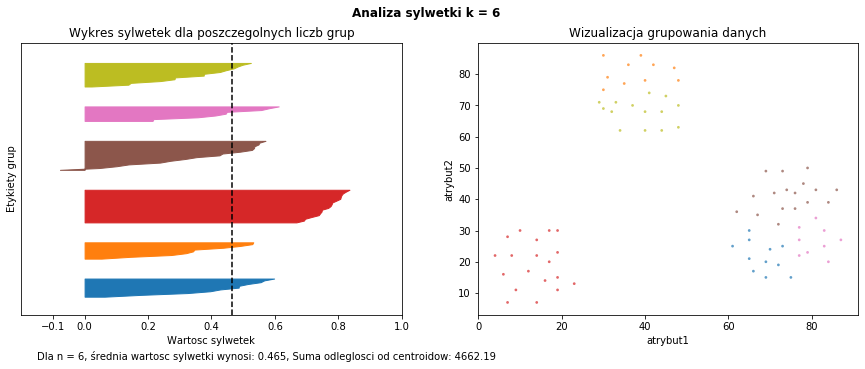

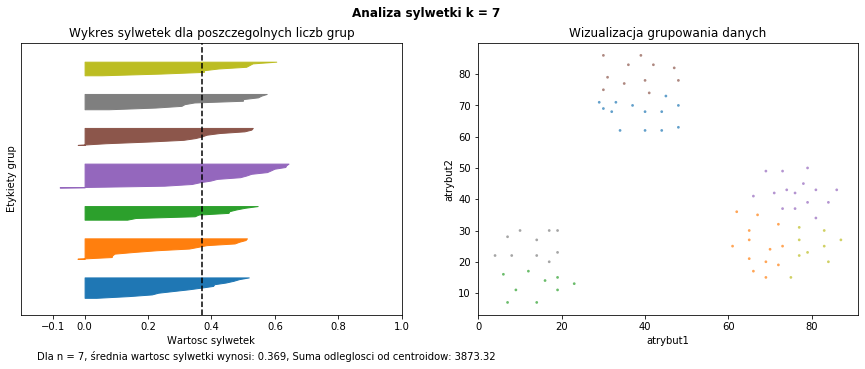

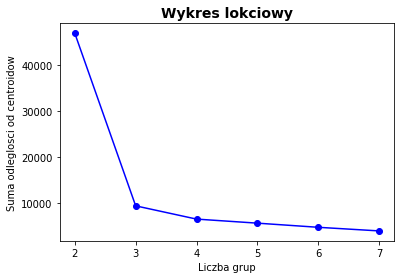

In [18]:
df = pd.read_csv('dane1.csv', usecols = range(0,2))
big_function(df , range(2,8), ['atrybut1','atrybut2'])

> **Zadanie 3** Wykonaj grupowanie danych zbioru `iris` metodą k-średnich. Określ optymalne paramtery grupowania  (liczbę grup, typ odległości). Określ obiema metodami (łokciową i sylwetki) jakia jest dla optymalna liczba grup.

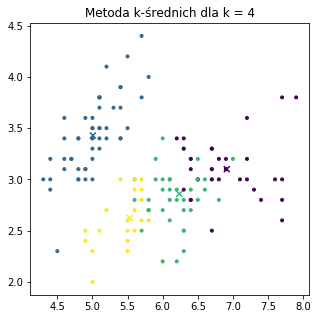

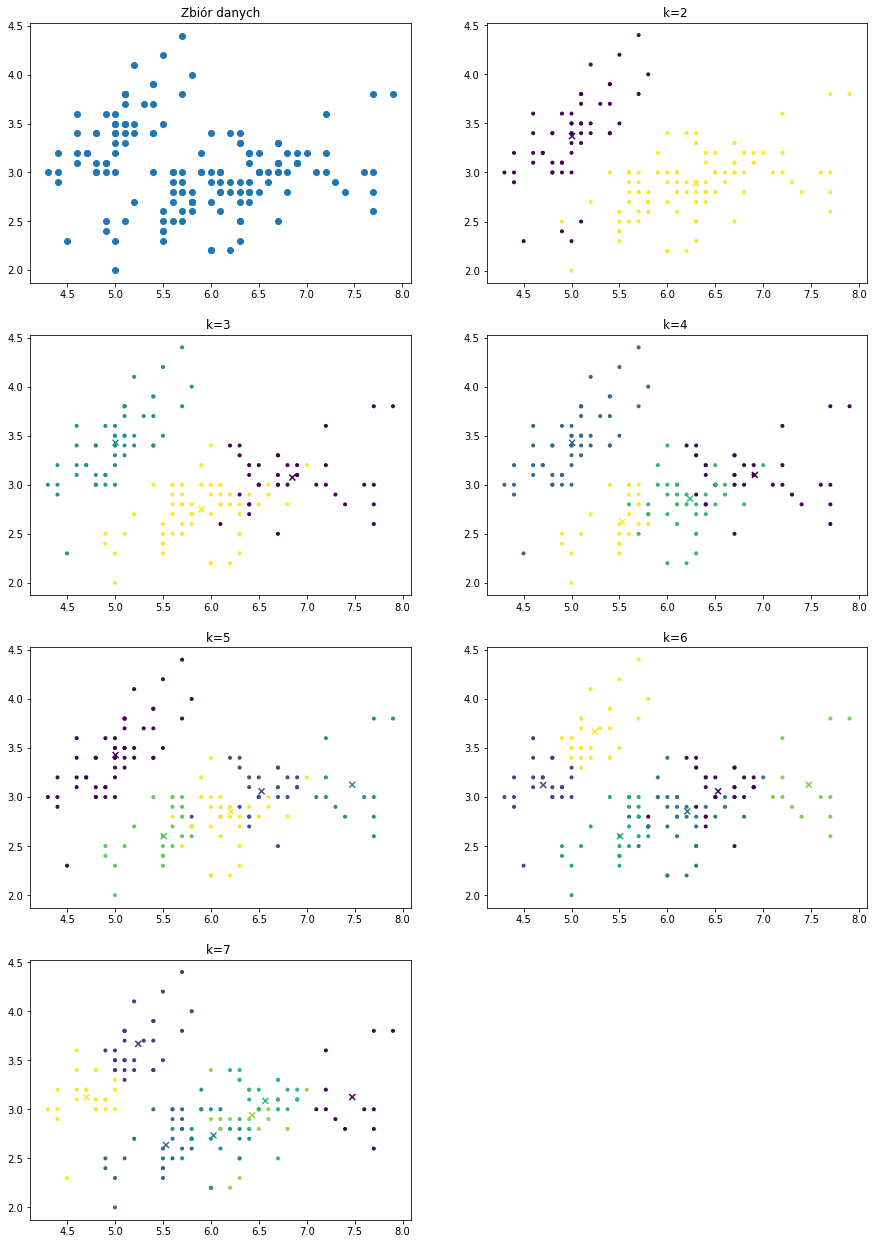

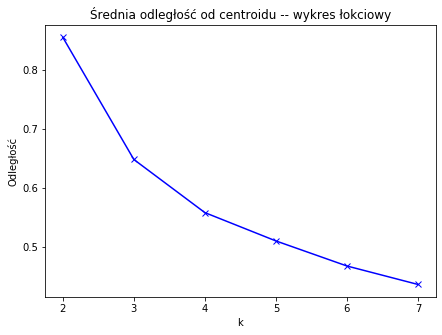

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


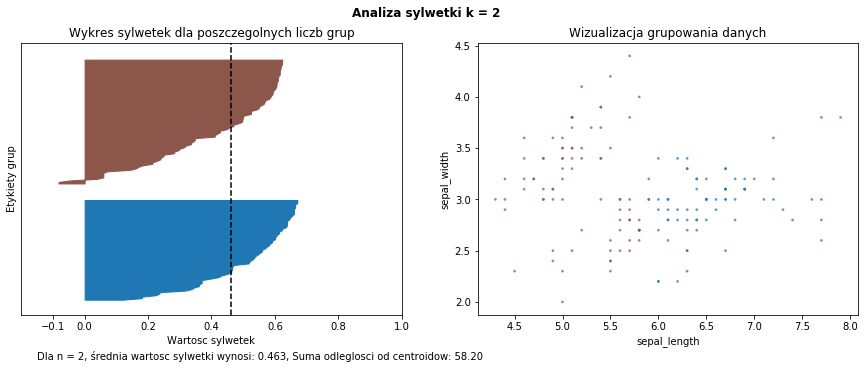

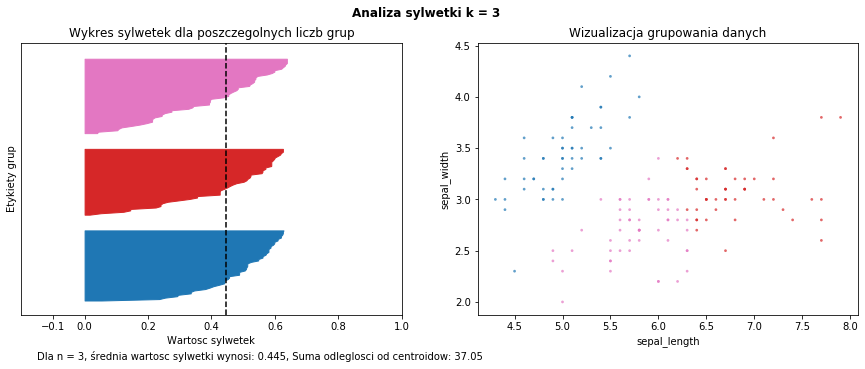

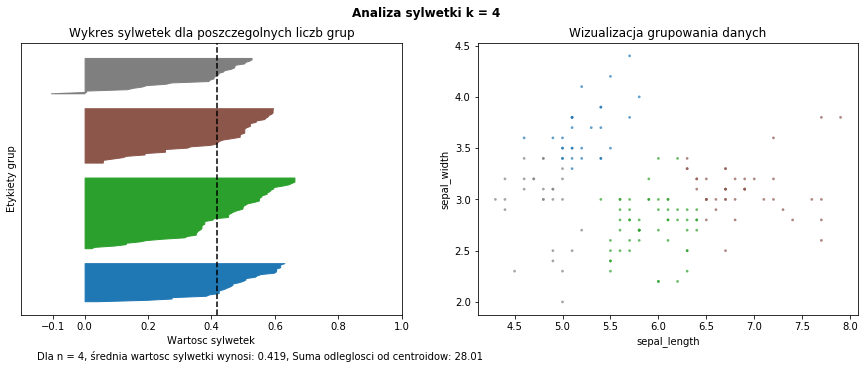

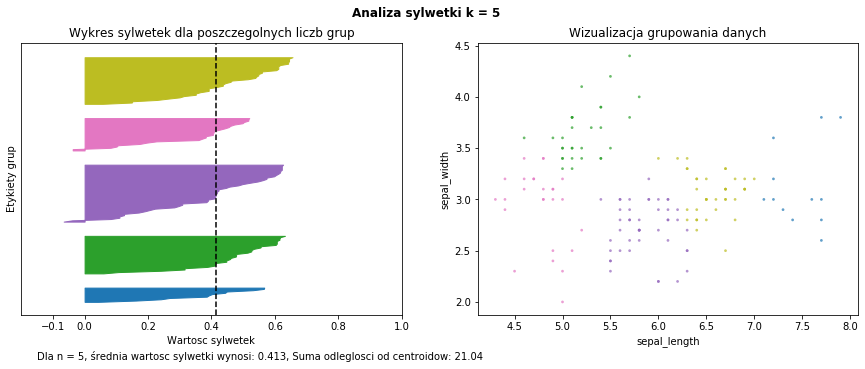

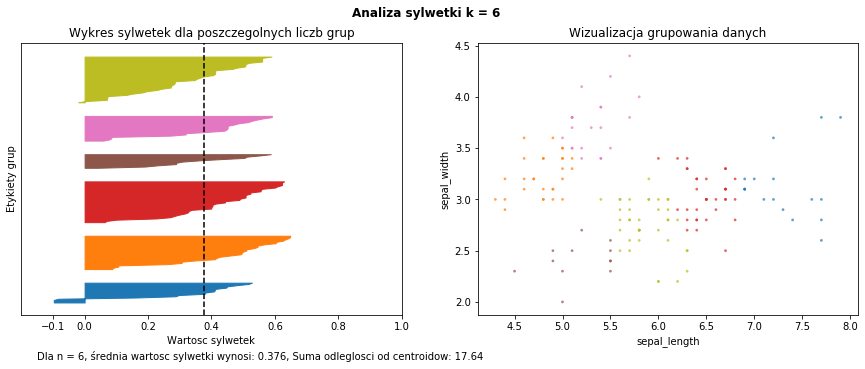

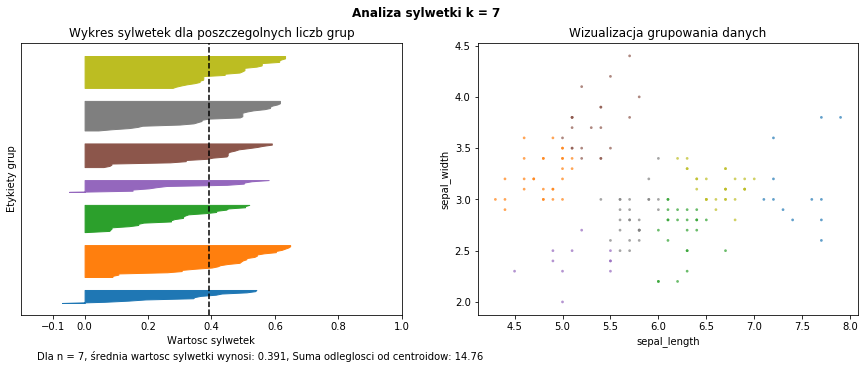

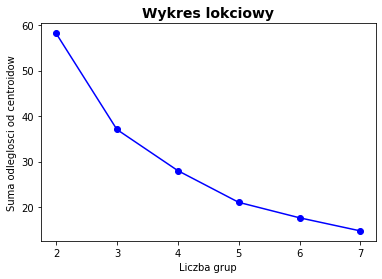

In [12]:
# kod
k = 4
df_org = pd.read_csv('iris.csv', index_col = 0)
df = df_org.drop(columns = ['species'])
kmeans = KMeans(n_clusters = k, random_state = 0)
kmeans.fit(df)
etykiety_klastrow = kmeans.fit_predict(df)
fig = plt.figure(figsize = (5,5))
plt.scatter(df.sepal_length, df.sepal_width, marker = '.', c = etykiety_klastrow)
centroidy = kmeans.cluster_centers_
plt.scatter(centroidy[:,0], centroidy[:,1], marker = 'x', c = np.array(range(k)))
plt.title('Metoda k-średnich dla k = %d' %k)
big_function(df, range(2,8), ['sepal_length','sepal_width']) #również wykorzystuje metodę k-średnich, stąd identyczny wynik dla zadanego k

Wnioski z analizy wyników zad. 3:
* najlepszym typem odległości jest w tym przypadku odległość euklidesowa
* optymalna liczba grup uzyskana metodą łokciową to 4-5, w tym też miejscu następuje wypłaszczenie wykresu łokciowego, suma odległości od centroidów stabilizująca się poniżej 20 to wynik zadowalający, pozwalający zakończyć grupowanie właśnie na poziomie 4 lub 5 grup
* zgodnie z dokładniejszą metodą sylwetek, uzyskujemy optymalny podział na poziomie 2 grup, gdzie wartość średnia sylwetki jest największa i wynosi 0,463
* grupowanie wykonano w zakresie liczb grup k od 2 do 7


> **Zadanie 4** Wygeneruj losowo zestaw transakcji w sklepie (15 produktów - "Produkt 1", "Produkt 2"...; 200 transakcji; ramka danych binarnych). Wyznacz dla przyjętych wartości wsparcia i ufności zestaw reguł asocjacyjnych dla tego zbioru.

In [11]:
#Przyjęta minimalna wartość wsparcia to 0.17, a ufności 0.65
df = pd.DataFrame(np.random.randint(0,2, size = (200,15)))
for i in range(1,16):
    col_name = 'Produkt ' + str(i)
    df.rename(columns = { (i - 1) : col_name}, inplace = True)
df.index.name = 'Klient'
df.columns.name = 'Nazwa produktu'
zbiory_czeste = apriori(df, min_support=0.17, use_colnames=True)
reguly = association_rules(zbiory_czeste, metric="lift", min_threshold=1)
reguly[reguly['confidence'] >= 0.65]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29,(Produkt 3),(Produkt 5),0.49,0.58,0.33,0.66,1.13,0.04,1.23
100,"(Produkt 1, Produkt 5)",(Produkt 3),0.27,0.49,0.19,0.72,1.46,0.06,1.80
101,"(Produkt 1, Produkt 3)",(Produkt 5),0.27,0.58,0.19,0.72,1.23,0.03,1.47
114,"(Produkt 3, Produkt 15)",(Produkt 5),0.24,0.58,0.17,0.73,1.25,0.03,1.53
132,"(Produkt 12, Produkt 4)",(Produkt 13),0.26,0.55,0.17,0.65,1.19,0.03,1.30
160,"(Produkt 15, Produkt 12)",(Produkt 13),0.28,0.55,0.18,0.65,1.19,0.03,1.30


> **Zadanie 5** Zmień nazwę tego skryptu na następującą "PRiAD4_Imię_Nazwisko.ipynb" i wgraj wgraj go do ISOD-a we wskazane miejsce, nie przekraczając wyznaczonego terminu.